In [1]:
import pandas as pd
import re
from sklearn import metrics
from sklearn.cluster import DBSCAN,OPTICS,Birch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
import numpy as np
import matplotlib.pyplot as plt 
from functions import *
import math
import hdbscan


# to ignore "DtypeWarning", generated due to reading csv files
import warnings
warnings.filterwarnings("ignore")


In [2]:
# part 3

products_DataSet = pd.read_csv('Data set/PRODUCTS.csv')

productInstance_DataSet = pd.read_csv('Data set/PRODUCTINSTANCE.csv', encoding='cp1252')

productInstance = productInstance_DataSet[['M_PRODUCT_ID',"BOOKVALUE"]].copy()
products = products_DataSet[['M_PRODUCT_ID','NAME',"VALUE"]].copy()

In [3]:

print("*****************running*******************")
ls = []
for i,record in enumerate(products['NAME']):
    s1 = re.search(' . .',record)
    s2 = re.search(' .',record)
    if s1 :
        if s1.end() == len(record) and s1.start() == len(record)-4:

            if type(products.VALUE[i]) != type(1):
                try:
                    products.VALUE[i] = pd.to_numeric(products.VALUE[i]) 
                    products.VALUE[i] /= 100000000

                except ValueError:
                    products.VALUE[i] = products.VALUE[i][:len(products.VALUE[i])-8]


    elif s2 :
        if s2.end() == len(record) and s2.start() == len(record)-2:
            if type(products.VALUE[i]) != type(1):
                try:
                    products.VALUE[i] = pd.to_numeric(products.VALUE[i]) 
                    products.VALUE[i] /= 10000

                except ValueError:
                    products.VALUE[i] = products.VALUE[i][:len(products.VALUE[i])-4]
                    products.VALUE[i] = int(products.VALUE[i])


    try:
        products.VALUE[i] = pd.to_numeric(products.VALUE[i]) 

    except ValueError:
        products.VALUE[i] = products.VALUE[i][:len(products.VALUE[i])-4]
        products.VALUE[i] = pd.to_numeric(products.VALUE[i], errors='coerce') 
    

products['VALUE'] = products['VALUE'].astype('float64')


*****************running*******************


In [4]:

merged = pd.merge(left=products,right=productInstance,how='inner',left_on='M_PRODUCT_ID',right_on='M_PRODUCT_ID')


cleanData = merged[['NAME',"VALUE",'BOOKVALUE']].dropna()

Xc = cleanData[['VALUE','BOOKVALUE']].copy()


In [5]:
X = Xc.to_numpy()

X_train_np, X_test_np = train_test_split(X,test_size=0.3,shuffle=True,random_state=40)
 # type: ignore
# X_train_np = X_train.to_numpy()
#  # type: ignore
# X_test_np = X_test.to_numpy()
 # type: ignore


In [6]:

standard = MaxAbsScaler().fit(X_train_np)
train = standard.transform(X_train_np)
# test = standard.transform(X_test_np)


In [7]:


print('eps=0.00070,min_samples=10')
dbscan = DBSCAN(eps=0.000150,min_samples=3).fit(train)
# dbscan = OPTICS(min_samples=10,max_eps=0.00070).fit(train)
# dbscan = Birch(threshold=0.010,branching_factor=50).fit(train)
# dbscan = hdbscan.HDBSCAN(min_samples=3,min_cluster_size=4
# ,cluster_selection_epsilon=0.000180
# ,cluster_selection_method='eom'
# ,prediction_data=True).fit(train)

labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print('evaluating...')
print(f"Silhouette Coefficient: {metrics.silhouette_score(train, labels):.3f}")


eps=0.00070,min_samples=10
Estimated number of clusters: 126
Estimated number of noise points: 261
evaluating...
Silhouette Coefficient: 0.644


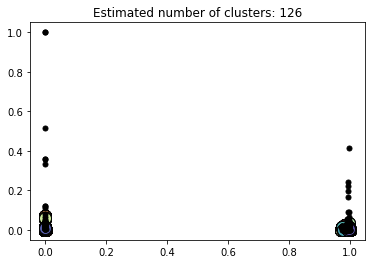

In [8]:

clusters = visualize(dbscan , labels , train, n_clusters_)


In [9]:


real_clusters = {}
value_boundary = {}
price_boundary = {}
price = {}

for key in clusters.keys():
    c = clusters.get(key)

    real_c = standard.inverse_transform(c)
    # real_c = c

    real_clusters[key] = real_c

    if key == -1:
        continue

    print(f"key: {key}")
    max = np.max(real_c[0])
    min = np.min(real_c[0])
    mean = np.mean(real_c[0])
    std = math.sqrt(np.var(real_c[0]))
    print(f"value min: {min} -- value max: {max}")
    print(f"mean: {mean} -- std: {std}")

    record = cleanData[(cleanData.VALUE >= min) & (cleanData.VALUE <= max)]

    upper_bound = mean+(2*std)
    lower_bound = mean-(2*std)
    print(f"value lower bound: {lower_bound} -- value upper bound: {upper_bound}")
    value_boundary[key] = (min,max,mean,std,lower_bound,upper_bound)


    max = np.max(real_c[1])
    min = np.min(real_c[1])
    mean = np.mean(real_c[1])
    std = math.sqrt(np.var(real_c[1]))
    

    print(f"price min: {min} -- price max: {max}")
    print(f"mean: {mean} -- std: {std}")

    prices_range = record[(record.BOOKVALUE >= min) & (record.BOOKVALUE <= max)]

    upper_bound = mean+(2*std)
    lower_bound = mean-(2*std)
    print(f"price lower bound: {lower_bound} -- price upper bound: {upper_bound}")
    price_boundary[key] = (min,max,mean,std,lower_bound,upper_bound)


    prices = prices_range['BOOKVALUE']

    prices_np = prices.to_numpy()

    price[key] = np.mean(prices_np)


    print(f"price mean: {price[key]} -- cluster size: {len(real_clusters[key])}")



key: 0
value min: 1.0 -- value max: 8.473310090003e+16
mean: 4.2366550450015e+16 -- std: 4.2366550450015e+16
value lower bound: -4.2366550450015e+16 -- value upper bound: 1.27099651350045e+17
price min: 1.0 -- price max: 8.473310000008e+16
mean: 4.236655000004e+16 -- std: 4.236655000004e+16
price lower bound: -4.236655000004e+16 -- price upper bound: 1.2709965000012e+17
price mean: 5129467.576594585 -- cluster size: 9971
key: 1
value min: 1.0 -- value max: 8.46531016e+16
mean: 4.23265508e+16 -- std: 4.23265508e+16
value lower bound: -4.23265508e+16 -- value upper bound: 1.269796524e+17
price min: 0.0 -- price max: 8.465100010007e+16
mean: 4.2325500050035e+16 -- std: 4.2325500050035e+16
price lower bound: -4.2325500050035e+16 -- price upper bound: 1.26976500150105e+17
price mean: 5055565.958912853 -- cluster size: 1534
key: 2
value min: 1.0 -- value max: 8.38122006e+16
mean: 4.19061003e+16 -- std: 4.19061003e+16
value lower bound: -4.19061003e+16 -- value upper bound: 1.257183009e+17
pr

In [10]:

maxBoundary = len(X_test_np)
index = []
for i in range(10):
    index.append(random_int(0,maxBoundary))



for i in index:
    flag=0
    itemValue = X_test_np[i][0]
    itemRealPrice = X_test_np[i][1]
    for key in real_clusters:
        if key == -1:
            continue
        
        
        min = np.maximum(value_boundary[key][0],value_boundary[key][4])
        max = np.minimum(value_boundary[key][1],value_boundary[key][5])

        if (itemValue >= min) and (itemValue < max):
            min = np.maximum(price_boundary[key][0],price_boundary[key][4])
            max = np.minimum(price_boundary[key][1],price_boundary[key][5])
            if (itemRealPrice >= min) and (itemRealPrice < max):
                print(f'value=<{itemValue}> price=<{itemRealPrice:.4f}> estimated price= {price[key]:.2f}')
                flag=1
                break

    if flag == 0:
        print("this data does not belongs to any cluster, so model cant predict its price")



value=<8.452600000005e+16> price=<1.0000> estimated price= 5129467.58
value=<8.448150010031e+16> price=<1.0000> estimated price= 5129467.58
value=<8.38121003e+16> price=<1.0000> estimated price= 5129467.58
value=<838130002.0> price=<6692199.0000> estimated price= 5129467.58
value=<843923001.0> price=<1.0000> estimated price= 5129467.58
value=<8.452600000005e+16> price=<1.0000> estimated price= 5129467.58
value=<8.439230010002e+16> price=<1.0000> estimated price= 5129467.58
value=<8.371960680000003e+16> price=<1.0000> estimated price= 5129467.58
value=<8.38111002e+16> price=<1.0000> estimated price= 5129467.58
value=<838111002.0> price=<1.0000> estimated price= 5129467.58
